# Analyse Bleu/Rouge ?

In [2]:
import numpy as np
import pandas as pd
from sacrebleu import BLEU
from rouge import Rouge 
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from reco_systems.filter import filter_df
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import *
import seaborn as sns

from reco_systems.CF_knn import calc_similarity_matrix, get_KNN
from random import choice

%load_ext autoreload
%autoreload 2

In [3]:
# Construction de la BDD avec avis centrés
avis = pd.read_csv("database_cleaned/avis_clean.csv", index_col = 0)
min_reviews = 10
rev_filter = filter_df(avis, min_reviews)
rev_filter = rev_filter[rev_filter["Comment body"].str.split().apply(len) >= 10]
filtered_centrd_data, _= center_score(rev_filter)

def concat_inplace(df1, df2) -> pd.DataFrame:
    return pd.concat([df1,df2], ignore_index=True)

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


In [4]:
np.random.seed(45)

matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(filtered_centrd_data)
# Construction assoc : les users qui notent le plus 
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(filtered_centrd_data)
user_inds = filtered_centrd_data[['User id', 'Game id']].groupby("User id").count().reset_index()
user_inds.columns = ["User id", "Count reviews"]
assoc = users_table.to_frame().merge(user_inds, on="User id", how="left").reset_index()
assoc.columns = ["User index", "User id", "Count reviews"]
assoc.sort_values(by='Count reviews', ascending=False,inplace=True)
assoc

users_table = pd.DataFrame(users_table)

lemmas = pd.read_csv('generated_data/avis_lemmatized.csv',index_col=0)

# Calcul matrice de similarité
sim_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, dist_type="cos")

def find_best_game(data : pd.DataFrame, user_ref_id : int, neighbours_id : np.array) -> int:
    """
    """

    neighbours_ratings = data[(data['User id']).isin(neighbours_id) | (data['User id'] == user_ref_id)]
    user_ref_games = data[data['User id'] == user_ref_id]['Game id'].to_numpy()

    df_filtered = neighbours_ratings[neighbours_ratings['User id'] != user_ref_id]
    game_avg_ratings = df_filtered.groupby('Game id')['Rating'].mean().reset_index()
    df_result = game_avg_ratings[game_avg_ratings['Game id'].isin(user_ref_games)]

    

    df_result = df_result.rename(columns={"Rating" : "Mean Rating"})
    df_result.sort_values("Mean Rating", ascending=False,inplace=True)
    
    return int(df_result.loc[df_result["Mean Rating"].idxmax(), "Game id"])

def prediction_rating(data, neighbourds_id, game_id):
    return np.mean(data[(data['User id'].isin(neighbourds_id)) & (data['Game id'] == game_id)]["Rating"].to_numpy())

def get_bleu_rouge(user_ref_id : int, neighbours_id : np.array, game_id : int, bleu = True):
    """ Si bleu, calcul bleu
    else, calcul rouge 
    """
    ref_avis = rev_filter[(rev_filter['User id'] == user_ref_id) & (rev_filter['Game id'] == game_id)].index[0]
    ref_lem = lemmas.loc[ref_avis,'Comment']

    get_id_avis = np.vectorize(lambda x: ( rev_filter[(rev_filter['User id'] == x) & (rev_filter['Game id'] == game_id)].index[0] if not rev_filter[(rev_filter['User id'] == x) & (rev_filter['Game id'] == game_id)].empty else -1 ) )

    neighbours_avis = get_id_avis(neighbours_id)
    neighbours_avis = neighbours_avis[neighbours_avis != -1]
    neighbours_lem = np.apply_along_axis(lambda x : lemmas.loc[x, "Comment"], axis=0, arr=neighbours_avis).tolist()
    if(bleu):
        blue_scorer = BLEU()
        res = np.apply_along_axis(lambda x : blue_scorer.sentence_score(hypothesis=str(x),references=[ref_lem]).score, axis=0, arr=neighbours_lem)
    else :
        rouge_score =  Rouge()
        g = np.vectorize(lambda x : rouge_score.get_scores(hyps=x,refs=ref_lem)[0]["rouge-l"]["f"]*100)
        res = g(neighbours_lem)
    return np.mean(res)





f = np.vectorize(lambda x : users_table.iloc[x]['User id'])


In [43]:
# Type d'évaluation 1 : jeux biens prédits parmi les 50 plus gros users (avec les 20 users les plus proches)

bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
famous_users = assoc.head(50)["User index"].to_numpy()
df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,20,x))
print("Taill res : ",  len(get_KNN(sim_matrix,20,1)))
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")


Taill res :  20


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

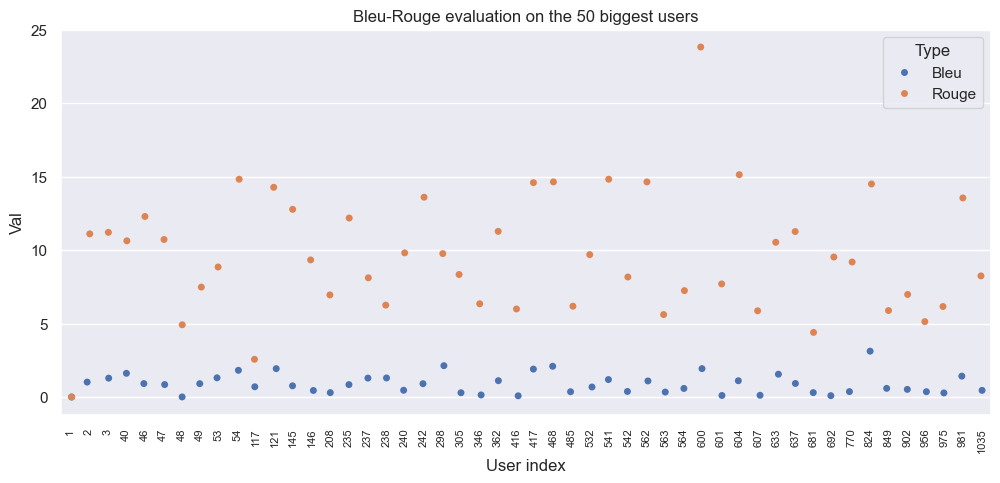

In [45]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("Bleu-Rouge evaluation on the 50 biggest users")
plt.savefig('img_bleu_rouge/50_big_close.png')

In [46]:
# Type d'évaluation 2 : 50 plus gros users parmi les mieux prédits (knn 20 users) 

bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
famous_users = assoc.head(112)["User index"].to_numpy()
df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,20,x))
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

df = df[abs(df['Pred Rating'] - df['Real Rating']) <2]

df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

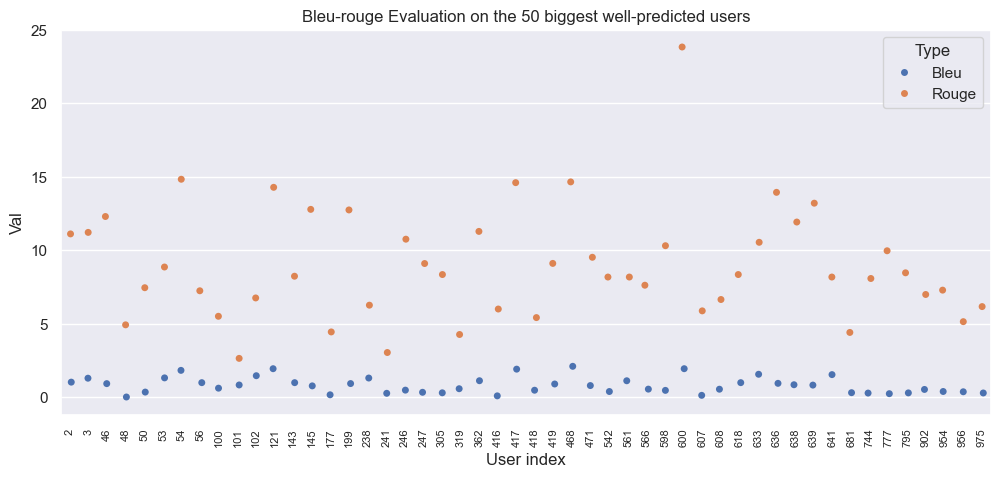

In [47]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("Bleu-rouge Evaluation on the 50 biggest well-predicted users")
plt.savefig('img_bleu_rouge/50_predict_close.png')

In [48]:
# Type d'évaluation 3 : 50 plus gros users parmis les mals prédits 

bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
famous_users = assoc.head(112)["User index"].to_numpy()
df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,20,x))
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

df = df[abs(df['Pred Rating'] - df['Real Rating']) >=3]

df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

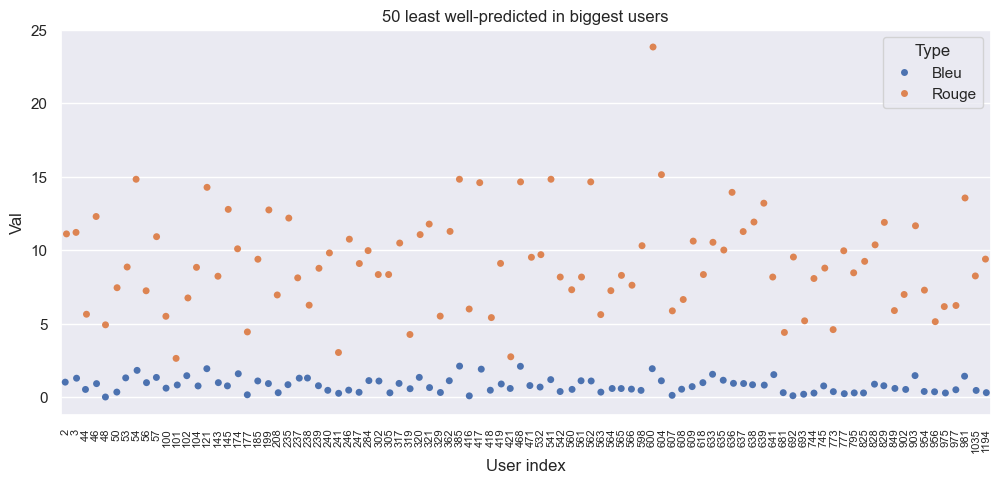

In [ ]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("50 least well-predicted in biggest users")
plt.savefig('img_bleu_rouge/50_bad_predict_close.png')

In [12]:
# Type d'évaluation 4 : 50 users random
import random
bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
famous_users = random.sample(sorted(assoc["User index"].to_numpy()), k=50)
df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,20,x))
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

#df = df[abs(df['Pred Rating'] - df['Real Rating']) >=3]

df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

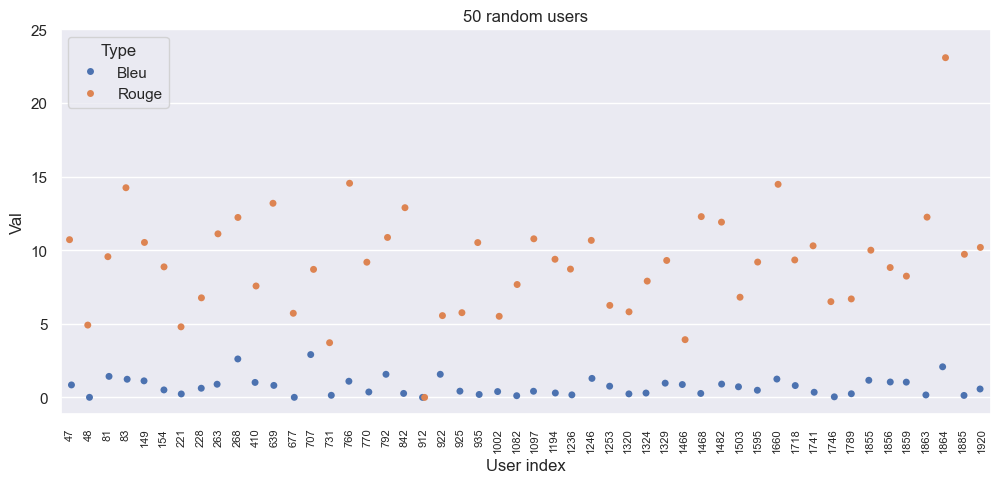

In [13]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("50 random users")
plt.savefig('img_bleu_rouge/50_random_close.png')

In [14]:
# Type 5 :users les plus distants pour users random
# Type d'évaluation 4 : 50 users random
import random
bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
#famous_users = random.sample(sorted(assoc["User index"].to_numpy()), k=50)
df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,filtered_centrd_data.shape[0],x)[-20:])
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

#df = df[abs(df['Pred Rating'] - df['Real Rating']) >=3]

df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

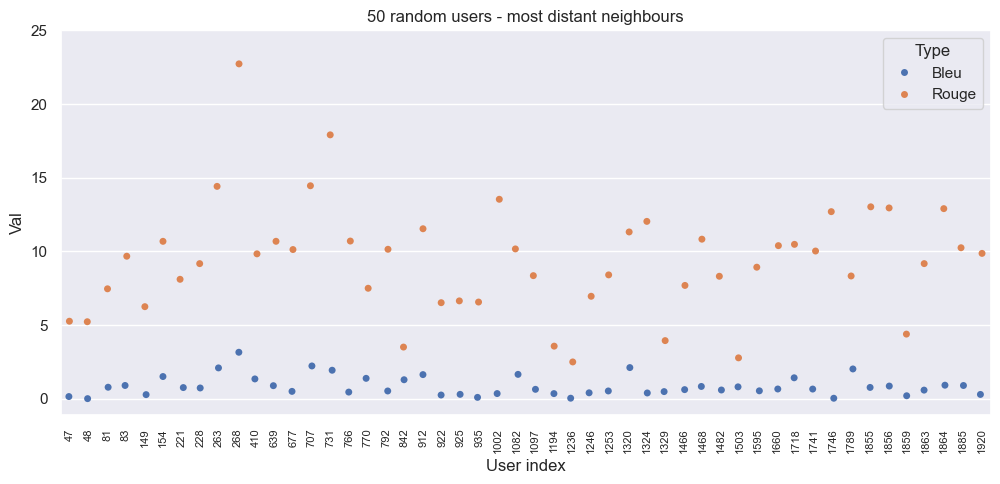

In [16]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("50 random users - most distant neighbours")
plt.savefig('img_bleu_rouge/50_random_far.png')

In [17]:
# Type 6 :users les plus distants pour users random

import random
bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
famous_users = assoc.head(50)["User index"].to_numpy()
df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,filtered_centrd_data.shape[0],x)[-20:])
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

#df = df[abs(df['Pred Rating'] - df['Real Rating']) >=3]

df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

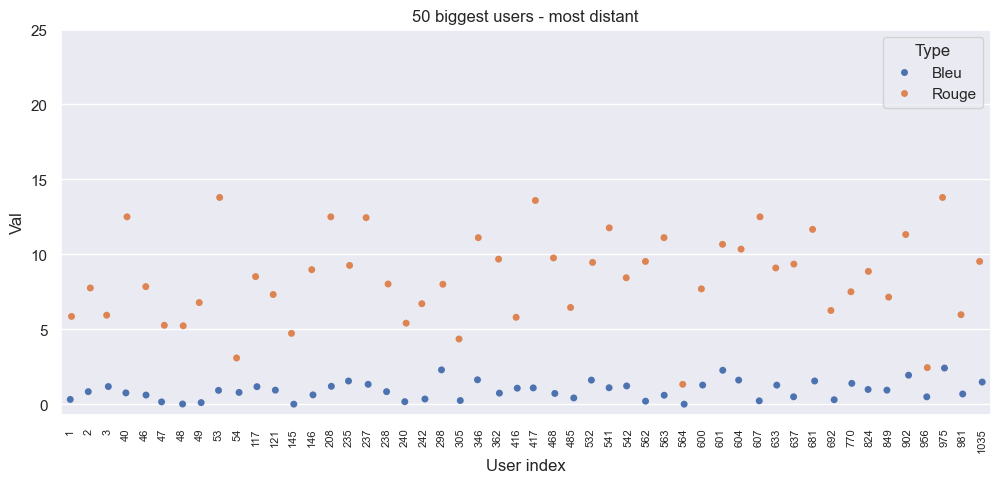

In [19]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("50 biggest users - most distant")
plt.savefig('img_bleu_rouge/50_big_far.png')

In [37]:
# Type d'évaluation 7 : 50 plus gros users bien prédits  - users distants

bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
famous_users = assoc.head(500)["User index"].to_numpy()
df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,filtered_centrd_data.shape[0],x)[-20:])
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

df = df[abs(df['Pred Rating'] - df['Real Rating']) <2]

df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

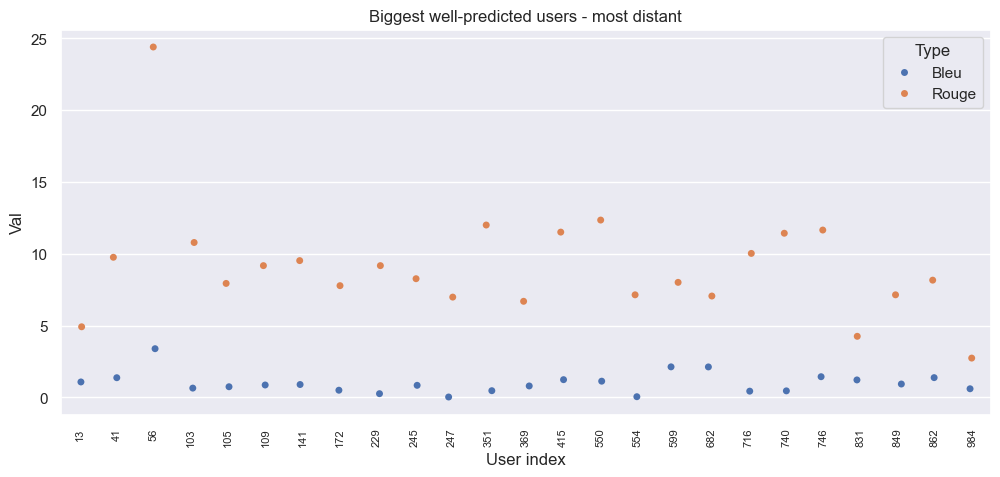

In [38]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("Biggest well-predicted users - most distant")
plt.savefig('img_bleu_rouge/50_predict_far.png')

In [41]:
# Type d'évaluation 8 : 50 plus gros users mal prédits - distants 

bleu_rouge = pd.DataFrame(columns=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment','Type','Val']) # reset every box
famous_users = assoc.head(70)["User index"].to_numpy()
df = pd.DataFrame(famous_users, columns=['User index'])
df['Voisins index'] = df['User index'].apply(lambda x : get_KNN(sim_matrix,filtered_centrd_data.shape[0],x)[-20:])
df['Recommended game'] = df.apply(
    lambda x: find_best_game(
        filtered_centrd_data,
        users_table.iloc[x['User index']]['User id'],
        f(x['Voisins index'])), 
    axis=1)
df['Pred Rating'] = df.apply(lambda x : prediction_rating(rev_filter,f(x['Voisins index']),x['Recommended game']),axis=1)
df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

df = df[abs(df['Pred Rating'] - df['Real Rating']) >=3]

df['Bleu'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game']), axis=1)
df['Rouge'] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], f(x['Voisins index']), x['Recommended game'],bleu=False), axis=1)
bleu_rouge = pd.melt(df,id_vars=['User index', 'Voisins index', 'Recommended game', 'Pred Rating', 'Real Rating'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")

It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is 

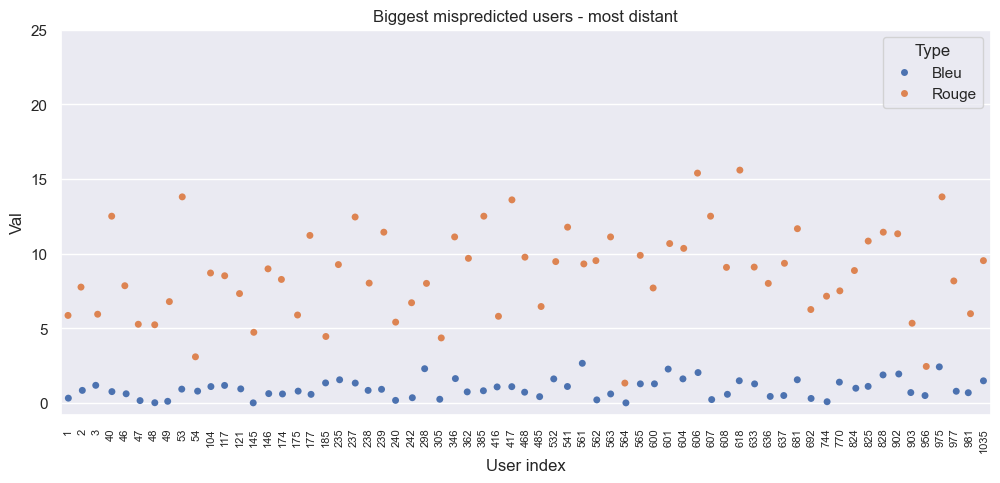

In [42]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User index", y="Val",hue="Type")
plt.yticks(ticks=range(0,30,5),labels=range(0,30,5))
plt.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("Biggest mispredicted users - most distant")
plt.savefig('img_bleu_rouge/50_bad_predict_far.png')

In [13]:

rev_filter # data centrée

np.random.seed(45)
# Tirer un user au hasard 
# k-NN sur 20
# regarder le jeu qui a le plus de user commun
# generate user-game matrix

# Construction assoc


# Sélection aléatoire user
user_indices = assoc["User index"].to_numpy()





print(famous_users)

for user in famous_users : 
# df : user_ref_id (le vrai), game_id évalué, voisin id, avis du voisin id, bleu, rouge
    #user = choice(user_indices)
    user_ind = assoc.loc[user,"User id"]
    print(user, " : ", user_ind)

    # k-nn
    neighbours = get_KNN(sim_matrix,20,user)
    print("Voisins : ", neighbours)

    neighbours_id = assoc[ np.isin(assoc['User index'],neighbours)]['User id'].to_numpy()
    neighbours_id
    neighbours_avis = filtered_centrd_data[(filtered_centrd_data['User id'].isin(neighbours_id)) | (filtered_centrd_data['User id'] == user_ind)]
    # Filtrer les jeux notés par user_ind
    user_games = filtered_centrd_data[filtered_centrd_data["User id"] == user_ind]["Game id"].unique()

    # Exclure les notes du user_ind -> garder uniquement les voisins !!!!!
    df_filtered = neighbours_avis[neighbours_avis["User id"] != user_ind]
    # Calculer la moyenne des notes pour chaque jeu
    game_avg_ratings = df_filtered.groupby("Game id")["Rating"].mean().reset_index()

    # Garder uniquement les jeux que user_ind a notés
    df_result = game_avg_ratings[game_avg_ratings["Game id"].isin(user_games)]
    # Renommer la colonne moyenne des notes
    df_result = df_result.rename(columns={"Rating": "Mean Rating"})
    df_result.sort_values('Mean Rating', ascending=False,inplace=True)

    best_game = df_result.loc[df_result["Mean Rating"].idxmax(), "Game id"]
    print("Jeu reco : ",int(best_game))
    df_result.head(10)

    neighbours_avis = neighbours_avis[neighbours_avis['Game id'] == best_game][['User id','Game id']]
    #df = ft.get_bleu_rouge(best_game,user_ind,assoc,neighbours,neighbours_avis)
    print("ID des voisins et du joueur : ", neighbours_avis['User id'].to_numpy())
    print("ID du ref : ",user_ind)
    ref_avis = rev_filter[(rev_filter['User id'] == user_ind) & (rev_filter['Game id'] == best_game)].index[0]
    print("Ref avis :", ref_avis)
    br = neighbours_avis.copy(True)
    br = br[br['User id'] != user_ind].reset_index()
    br.drop('Game id', axis = 1, inplace=True)
    br.columns = ['Avis id', 'User id']
    br.sort_values('Avis id', ascending=True)

    lem = pd.read_csv('generated_data/avis_lemmatized.csv',index_col=0)
    #lem_n = lem[np.isin(lem.index, br['Avis id'].to_numpy())]
    br = br.merge(lem,left_on='Avis id', right_index=True, how="inner") # merge left on right_index = True, left_on avis id
    #br['Lemma'] = lem_n['Comment'].to_numpy()
    #if(ref_avis not in lem.index) : continue
    ref_lem = lem.loc[ref_avis,'Comment']

    blue_scorer = BLEU()
    rouge_scorer = Rouge()

    br['Bleu'] = br['Comment'].apply(lambda x : blue_scorer.sentence_score(hypothesis=x,references=[ref_lem]).score/100)
    #br['Bleu nltk'] = br['Comment'].apply(lambda x : bleu_score.sentence_bleu(hypothesis=[list(x)],references=ref_lem))
    br['Rouge'] = br['Comment'].apply(lambda x : rouge_scorer.get_scores(hyps=x,refs=ref_lem)[0]["rouge-l"]["f"])
    br['User ref'] = [user_ind]*br.shape[0]
    br['Game rec'] = [best_game]*br.shape[0]
    br = br[['User ref', 'Game rec', 'Avis id', 'User id', 'Comment', 'Bleu', 'Rouge']]

    #bleu_rouge = pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")
    #bleu_rouge = pd.concat([bleu_rogue,pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)
    bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)
bleu_rouge['Val'] = bleu_rouge['Val'].apply(lambda x : x*100)
bleu_rouge['User ref'] = bleu_rouge['User ref'].apply(lambda x : str(x))

[np.int64(893), np.int64(1043), np.int64(118), np.int64(1937), np.int64(692), np.int64(1406), np.int64(183), np.int64(581), np.int64(1495), np.int64(273), np.int64(1272), np.int64(17), np.int64(885), np.int64(1682), np.int64(1172), np.int64(362), np.int64(1140), np.int64(654), np.int64(197), np.int64(1195), np.int64(1878), np.int64(1800), np.int64(176), np.int64(1717), np.int64(541), np.int64(1539), np.int64(185), np.int64(1547), np.int64(378), np.int64(909), np.int64(297), np.int64(650), np.int64(1278), np.int64(1052), np.int64(570), np.int64(1524), np.int64(1726), np.int64(568), np.int64(939), np.int64(86), np.int64(1381), np.int64(288), np.int64(395), np.int64(1748), np.int64(1458), np.int64(1242), np.int64(559), np.int64(727), np.int64(29), np.int64(442)]
893  :  2552
Voisins :  [1257  344 1792  114  387 1641 1468 1217 1050 1473 1156 1756 1595  632
 1086 1017 1467 1627 1535  438]
Jeu reco :  6610
ID des voisins et du joueur :  [2552 4376 6612 6206]
ID du ref :  2552
Ref avis : 5468

It is recommended to enable `effective_order` for sentence-level BLEU.


1043  :  3002
Voisins :  [ 747 1584  312 1745   80 1062 1539  856 1293 1786  631 1905  358  391
  326  630 1775  671 1092  632]
Jeu reco :  5240
ID des voisins et du joueur :  [2246 3002 6151]
ID du ref :  3002
Ref avis : 98577


C:\Users\arlyc\AppData\Local\Temp\ipykernel_19380\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


118  :  202
Voisins :  [1552  510 1398 1530  376  795 1280  455  976  821 1297 1543  724  860
 1391 1722 1828 1533  846  511]
Jeu reco :  1789
ID des voisins et du joueur :  [ 202 3682]
ID du ref :  202
Ref avis : 50279


It is recommended to enable `effective_order` for sentence-level BLEU.


1937  :  9066
Voisins :  [1930 1403  136 1906 1863 1523 1521 1477  876 1321  589  493  276 1698
  811  645  265 1455  454  653]
Jeu reco :  8136
ID des voisins et du joueur :  [1948 9066]
ID du ref :  9066
Ref avis : 89714


It is recommended to enable `effective_order` for sentence-level BLEU.


692  :  2049
Voisins :  [ 298  748  717 1585  362  121 1387  635  145  601  691  853  982  833
  975  101  778  796  902  510]
Jeu reco :  2549
ID des voisins et du joueur :  [ 208 2049]
ID du ref :  2049
Ref avis : 34360


It is recommended to enable `effective_order` for sentence-level BLEU.


1406  :  4131
Voisins :  [1409  762  544 1812 1067  948 1168 1468  801 1247  764 1928 1842  711
  454 1453 1376  919 1166   78]
Jeu reco :  1444
ID des voisins et du joueur :  [4328 2306 3072 4131]
ID du ref :  4131
Ref avis : 115270


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


183  :  400
Voisins :  [ 312  758 1062  698  630 1150 1333  131   37  340  873  913  929  889
  652   51  326  787  358  114]
Jeu reco :  7854
ID des voisins et du joueur :  [ 400  253 2257  864 2548  187]
ID du ref :  400
Ref avis : 19459


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


581  :  1835
Voisins :  [1456 1600  575  803   52 1605   48  531 1650 1742  410 1061 1751 1416
  825  769 1771 1468 1497 1717]
Jeu reco :  6110
ID des voisins et du joueur :  [1829 4902 1835]
ID du ref :  1835
Ref avis : 134453


It is recommended to enable `effective_order` for sentence-level BLEU.


1495  :  4476
Voisins :  [1149   91 1568 1605  388 1146  680 1604  170  555  273 1657   32 1139
  437 1698 1514 1705 1773  572]
Jeu reco :  2466
ID des voisins et du joueur :  [4476 4906]
ID du ref :  4476
Ref avis : 114306


It is recommended to enable `effective_order` for sentence-level BLEU.


273  :  613
Voisins :  [ 701 1149  275 1635 1711   94   85 1730 1391   76 1495  332  279  266
   57  785  858  274   72  421]
Jeu reco :  8574
ID des voisins et du joueur :  [ 613 6059]
ID du ref :  613
Ref avis : 105245


It is recommended to enable `effective_order` for sentence-level BLEU.


1272  :  3670
Voisins :  [1061  627  233 1497  287  117  681 1141 1810  777 1299 1068  966  615
 1877  613  410  723  239  385]
Jeu reco :  8316
ID des voisins et du joueur :  [ 578 3670]
ID du ref :  3670
Ref avis : 122552


It is recommended to enable `effective_order` for sentence-level BLEU.


17  :  23
Voisins :  [  30  255  195  134   31  356  109  472  739  164  139  202   81  338
  725  296 1430  225  366  484]
Jeu reco :  8702
ID des voisins et du joueur :  [2183 2204   23]
ID du ref :  23
Ref avis : 85930


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


885  :  2544
Voisins :  [1672 1671 1308 1490 1577  768 1342 1447 1924 1263  989  587 1305  562
 1822 1843 1482 1500 1929  766]
Jeu reco :  1079
ID des voisins et du joueur :  [2544 1816]
ID du ref :  2544
Ref avis : 16663


C:\Users\arlyc\AppData\Local\Temp\ipykernel_19380\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


1682  :  5282
Voisins :  [1353  377 1679  104 1334 1170  405 1753 1462  363 1685   73 1543 1583
 1519  240 1091 1415 1917  164]
Jeu reco :  3568
ID des voisins et du joueur :  [4337 5282 6177]
ID du ref :  5282
Ref avis : 105864


It is recommended to enable `effective_order` for sentence-level BLEU.


1172  :  3368
Voisins :  [1916 1515 1891 1915  402 1655  649  486 1450   83 1055  122  380  490
  201 1847 1346  990 1292  253]
Jeu reco :  8640
ID des voisins et du joueur :  [ 437 3368]
ID du ref :  3368
Ref avis : 30818


It is recommended to enable `effective_order` for sentence-level BLEU.


362  :  934
Voisins :  [ 662  692  188  117 1765  975  283 1530  298  873 1046  101  121  690
 1191  774  566   57    1 1520]
Jeu reco :  3788
ID des voisins et du joueur :  [208 934]
ID du ref :  934
Ref avis : 90762


It is recommended to enable `effective_order` for sentence-level BLEU.


1140  :  3242
Voisins :  [1094  589 1687 1534 1936 1316 1394  896 1666 1756 1872  445 1929 1571
  955  375 1471  253 1847 1098]
Jeu reco :  1443
ID des voisins et du joueur :  [3242 7052]
ID du ref :  3242
Ref avis : 62394


C:\Users\arlyc\AppData\Local\Temp\ipykernel_19380\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


654  :  1958
Voisins :  [1891  752  762 1606 1550 1259  994 1447  781  402 1231  637 1160 1062
 1278  883 1244 1241 1729  739]
Jeu reco :  8702
ID des voisins et du joueur :  [1940 2542 1958 2204]
ID du ref :  1958
Ref avis : 85872


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


197  :  426
Voisins :  [ 427   98  109  254  951    1 1426 1725  818  844  307  297  220  390
 1147  158 1655   46  182 1357]
Jeu reco :  112
ID des voisins et du joueur :  [   1   91  333 3303 5147 3933 4190 6031  426 2732 2338]
ID du ref :  426
Ref avis : 46441


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


1195  :  3429
Voisins :  [1716 1670 1942 1629 1921  671  590  343 1905 1692  841  605  930 1838
 1439  922  986 1506  517 1904]
Jeu reco :  7845
ID des voisins et du joueur :  [1904 3429]
ID du ref :  3429
Ref avis : 127589


C:\Users\arlyc\AppData\Local\Temp\ipykernel_19380\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


1878  :  7407
Voisins :  [1316 1895  739 1590 1915  642 1838  832  502  344 1805  728 1516  803
 1834 1063 1396 1243 1828 1621]
Jeu reco :  6352
ID des voisins et du joueur :  [4979 1508 6889 7407 4820]
ID du ref :  7407
Ref avis : 89021


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


1800  :  6686
Voisins :  [1504 1498  228  756 1801 1362  873 1424 1408 1324  692 1869  741 1126
  671  317 1780 1165 1889 1238]
Jeu reco :  3578
ID des voisins et du joueur :  [2049 6686]
ID du ref :  6686
Ref avis : 74861


It is recommended to enable `effective_order` for sentence-level BLEU.


176  :  383
Voisins :  [ 384 1271   46 1080  192  850 1190  662 1023  859  464 1188  121 1828
  537  692  972  346 1480 1720]
Jeu reco :  3038
ID des voisins et du joueur :  [208 383]
ID du ref :  383
Ref avis : 56860


It is recommended to enable `effective_order` for sentence-level BLEU.


1717  :  5749
Voisins :  [ 836 1775  839 1895 1414 1922 1456  772   94  610 1261  581 1061  735
  615   92   76   80  233 1793]
Jeu reco :  8597
ID des voisins et du joueur :  [2396 2399 5749]
ID du ref :  5749
Ref avis : 120327


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


541  :  1724
Voisins :  [ 117  563   59  773  942  633  235  471  121  243  615  374  627  598
  634  856  570 1004 1067 1157]
Jeu reco :  5237
ID des voisins et du joueur :  [ 208 1724]
ID du ref :  1724
Ref avis : 73748


C:\Users\arlyc\AppData\Local\Temp\ipykernel_19380\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


1539  :  4627
Voisins :  [ 632 1589  595 1293  651 1813  944 1042   70 1247 1043  250 1343 1772
   61 1686  776 1139 1698 1705]
Jeu reco :  5666
ID des voisins et du joueur :  [2707 4627 5349]
ID du ref :  4627
Ref avis : 83244


It is recommended to enable `effective_order` for sentence-level BLEU.


185  :  403
Voisins :  [1166  941  928  420 1771  879 1345  985   67  626  121 1534  120  365
  172  293 1058  312  903  681]
Jeu reco :  2267
ID des voisins et du joueur :  [208 403]
ID du ref :  403
Ref avis : 80117


C:\Users\arlyc\AppData\Local\Temp\ipykernel_19380\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


1547  :  4657
Voisins :  [ 328   56 1034  487 1401  874  255  920  291 1355  306  322 1475 1388
  102  713   26  438 1171  716]
Jeu reco :  2535
ID des voisins et du joueur :  [ 790 4657]
ID du ref :  4657
Ref avis : 49962


It is recommended to enable `effective_order` for sentence-level BLEU.


378  :  982
Voisins :  [  24  327   10  596  167 1095  388  303  389  187  267  402  500    4
  406  289  193  698  155 1143]
Jeu reco :  6270
ID des voisins et du joueur :  [982 820  15 606]
ID du ref :  982
Ref avis : 4988


It is recommended to enable `effective_order` for sentence-level BLEU.


909  :  2591
Voisins :  [ 879 1362 1335 1617   50  880  943  889  985  890 1159  758  447 1836
  895  963 1126  471 1101   53]
Jeu reco :  9727
ID des voisins et du joueur :  [2591 3336]
ID du ref :  2591
Ref avis : 135604


It is recommended to enable `effective_order` for sentence-level BLEU.


297  :  692
Voisins :  [ 301  181    8  137  168  307  811  220  288  323  390  108  197 1637
  411  106  221  271   41   35]
Jeu reco :  7018
ID des voisins et du joueur :  [ 610 2316  653  692   10 5100]
ID du ref :  692
Ref avis : 6485


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


650  :  1954
Voisins :  [1447  402 1888 1862  781   86 1826 1692 1278 1550  968  671 1654 1280
 1482 1595   71 1716 1221  964]
Jeu reco :  245
ID des voisins et du joueur :  [1954 3682]
ID du ref :  1954
Ref avis : 137441


It is recommended to enable `effective_order` for sentence-level BLEU.


1278  :  3680
Voisins :  [1447  402 1862 1475 1826 1431 1210  781 1550  968  964  268 1797  650
 1241 1622  233 1573 1036 1221]
Jeu reco :  2315
ID des voisins et du joueur :  [3680 3449]
ID du ref :  3680
Ref avis : 105408


It is recommended to enable `effective_order` for sentence-level BLEU.


1052  :  3036
Voisins :  [1200 1475 1210 1592 1431  486   34  921 1206 1899  949 1135  619 1751
 1649 1584 1841 1622  576 1797]
Jeu reco :  7507
ID des voisins et du joueur :  [3036 3434]
ID du ref :  3036
Ref avis : 111785


C:\Users\arlyc\AppData\Local\Temp\ipykernel_19380\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


570  :  1824
Voisins :  [1120 1793 1035 1358 1039  505  471 1895  290 1637 1671 1456   52 1313
 1347  541  236  620  760  233]
Jeu reco :  8656
ID des voisins et du joueur :  [1724  575 1824 2259]
ID du ref :  1824
Ref avis : 127239


It is recommended to enable `effective_order` for sentence-level BLEU.


1524  :  4560
Voisins :  [ 966 1612 1018 1202 1672 1319 1308 1843  293 1924 1826 1445  507  989
 1822 1817  557 1500 1548  786]
Jeu reco :  1708
ID des voisins et du joueur :  [4560 1800]
ID du ref :  4560
Ref avis : 17277


It is recommended to enable `effective_order` for sentence-level BLEU.


1726  :  6052
Voisins :  [ 663 1694 1735 1065 1919 1633 1407 1525  157 1734 1723 1296 1856  680
 1779  660  645 1145 1397  678]
Jeu reco :  4416
ID des voisins et du joueur :  [6052 5053 7198 8326]
ID du ref :  6052
Ref avis : 131160


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


568  :  1822
Voisins :  [1053  371  386   44  121  417   60  843  841 1572  635  505  612  853
 1474 1068  575  844  787  954]
Jeu reco :  6000
ID des voisins et du joueur :  [ 208 1822]
ID du ref :  1822
Ref avis : 78994


It is recommended to enable `effective_order` for sentence-level BLEU.


939  :  2695
Voisins :  [ 326  550  354 1844 1837 1520 1142  119  483  594 1162  853  985 1286
 1354   35 1695 1358 1394 1420]
Jeu reco :  9136
ID des voisins et du joueur :  [2695 4162]
ID du ref :  2695
Ref avis : 21141


It is recommended to enable `effective_order` for sentence-level BLEU.


86  :  131
Voisins :  [1930 1403  136  650 1906  491 1863 1523  228 1497 1283 1408  493 1764
  876  678  997 1044  276    6]
Jeu reco :  3416
ID des voisins et du joueur :  [3003 1954 3685  131 1987]
ID du ref :  131
Ref avis : 133501


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


1381  :  4025
Voisins :  [1881  842 1761 1677 1012 1883  533 1303 1404 1864 1889 1936 1268 1258
 1537 1214   79  642  594  465]
Jeu reco :  7024
ID des voisins et du joueur :  [2402 4025]
ID du ref :  4025
Ref avis : 86090


It is recommended to enable `effective_order` for sentence-level BLEU.


288  :  653
Voisins :  [1630 1011  694  496    8 1187  713  976 1392  435  357 1886  297  811
 1433 1637  494   43  143  107]
Jeu reco :  7018
ID des voisins et du joueur :  [ 284 2316  653  692   10 5100]
ID du ref :  653
Ref avis : 6478


It is recommended to enable `effective_order` for sentence-level BLEU.


395  :  1068
Voisins :  [ 116  449 1191 1714 1074  628  717   97  500  306 1190  229  386  374
  859  902  178  863  852  769]
Jeu reco :  5919
ID des voisins et du joueur :  [2584  733 1068]
ID du ref :  1068
Ref avis : 36656


It is recommended to enable `effective_order` for sentence-level BLEU.


1748  :  6159
Voisins :  [ 663 1734 1397 1636 1051  210 1709 1690 1083  899 1236  776  573 1372
 1054 1685 1726 1470 1071  505]
Jeu reco :  6848
ID des voisins et du joueur :  [6159 1827]
ID du ref :  6159
Ref avis : 73388


It is recommended to enable `effective_order` for sentence-level BLEU.


1458  :  4333
Voisins :  [  94   89  918  523  858 1282 1746  571 1211 1710  958 1576 1744   61
 1745  852 1943 1222 1616  468]
Jeu reco :  2776
ID des voisins et du joueur :  [4333 6156 9701 5518  143]
ID du ref :  4333
Ref avis : 116056


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


1242  :  3599
Voisins :  [1819 1087  400 1933 1758  849 1827  471 1035  751 1532 1167  864  769
 1305  274 1686  868 1385 1142]
Jeu reco :  4910
ID des voisins et du joueur :  [3599 3276  614]
ID du ref :  3599
Ref avis : 105326


It is recommended to enable `effective_order` for sentence-level BLEU.


559  :  1810
Voisins :  [ 226  264  337   14  114 1852  691 1598   54 1467 1274  690  202   51
  526  330 1327  550  845  517]
Jeu reco :  2583
ID des voisins et du joueur :  [4896 1810 4343 1602]
ID du ref :  1810
Ref avis : 19205


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


727  :  2185
Voisins :  [ 546 1359 1176 1134  475 1336  985 1593  839  553 1546 1476  810  545
 1579   88 1841  299  615  543]
Jeu reco :  7206
ID des voisins et du joueur :  [2399 2185]
ID du ref :  2185
Ref avis : 125531


It is recommended to enable `effective_order` for sentence-level BLEU.


29  :  54
Voisins :  [ 163  460 1216  496  384  844   46  470  379  665  524 1496  770 1072
  692 1176 1846  130 1161  370]
Jeu reco :  319
ID des voisins et du joueur :  [2049   54]
ID du ref :  54
Ref avis : 43630


C:\Users\arlyc\AppData\Local\Temp\ipykernel_19380\349080577.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rouge, pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")],ignore_index=True)


442  :  1218
Voisins :  [1357  899 1325  387  897  997 1734  912 1532  474 1366  780  893 1641
 1468 1381 1217 1390 1077  608]
Jeu reco :  145
ID des voisins et du joueur :  [2282 2559 2594 2552 4595 4344 6076 3503 1218 5106 1022]
ID du ref :  1218
Ref avis : 60014


It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.
It is recommended to enable `effective_order` for sentence-level BLEU.


Text(0.5, 1.0, 'Répartition de la similarité sur ')

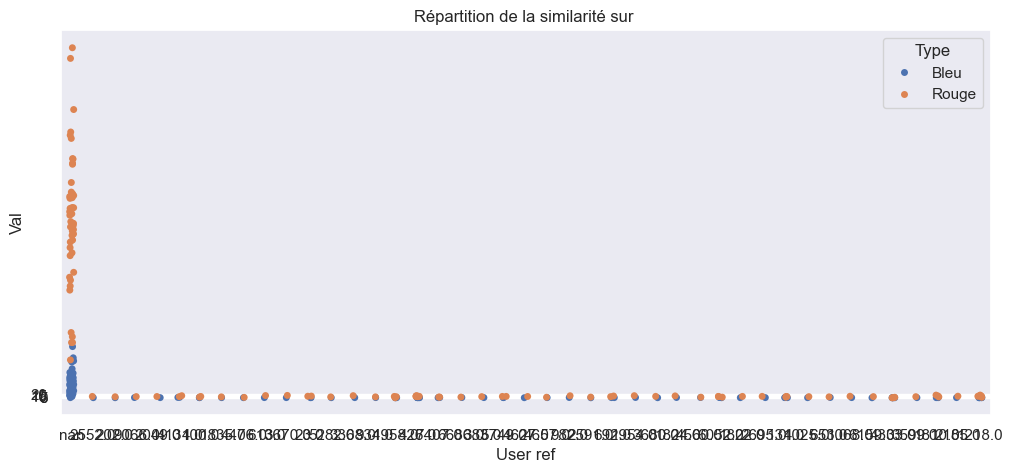

In [14]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
sns.stripplot(data=bleu_rouge, x="User ref", y="Val",hue="Type")
plt.yticks(ticks=range(0,25,5),labels=range(0,25,5))
plt.title("Répartition de la similarité sur ")

In [15]:
# problème de normalisation -> taille des commentaires
# Regarder répartition avec les joueurs aléatoires : voir si y a moins d'overlap qu'avec les joueurs proches
# Si c'est un peu le mm truc, c'est chiant
# doc = commentaire (tf-idf)









# Filtrer les jeux notés par user_ind
user_games = filtered_centrd_data[filtered_centrd_data["User id"] == user_ind]["Game id"].unique()

# Exclure les notes du user_ind -> garder uniquement les voisins !!!!!
df_filtered = neighbours_avis[neighbours_avis["User id"] != user_ind]
# Calculer la moyenne des notes pour chaque jeu
game_avg_ratings = df_filtered.groupby("Game id")["Rating"].mean().reset_index()

# Garder uniquement les jeux que user_ind a notés
df_result = game_avg_ratings[game_avg_ratings["Game id"].isin(user_games)]
# Renommer la colonne moyenne des notes
df_result = df_result.rename(columns={"Rating": "Mean Rating"})
df_result.sort_values('Mean Rating', ascending=False,inplace=True)

best_game = df_result.loc[df_result["Mean Rating"].idxmax(), "Game id"]
print(int(best_game))
df_result.head(10)

# Il faut filtrer avec l'avis sur le jeu de base

KeyError: 'Column not found: Rating'

In [ ]:
from nltk.translate import bleu_score
from sacrebleu import sentence_bleu
from rouge import Rouge

neighbours_avis = neighbours_avis[neighbours_avis['Game id'] == best_game][['User id','Game id']]
#df = ft.get_bleu_rouge(best_game,user_ind,assoc,neighbours,neighbours_avis)
print(neighbours_avis['User id'].to_numpy())
print(user_ind)
ref_avis = neighbours_avis[neighbours_avis['User id'] == user_ind].index[0]
br = neighbours_avis.copy(True)
br = br[br['User id'] != user_ind].reset_index()
br.drop('Game id', axis = 1, inplace=True)
br.columns = ['Avis id', 'User id']
br.sort_values('Avis id', ascending=True)

lem = pd.read_csv('generated_data/avis_lemmatized.csv',index_col=0)
#lem_n = lem[np.isin(lem.index, br['Avis id'].to_numpy())]
br = br.merge(lem,left_on='Avis id', right_index=True, how="inner") # merge left on right_index = True, left_on avis id
#br['Lemma'] = lem_n['Comment'].to_numpy()
ref_lem = lem.loc[ref_avis,'Comment']

blue_scorer = BLEU()
rouge_scorer = Rouge()

br['Bleu'] = br['Comment'].apply(lambda x : blue_scorer.sentence_score(hypothesis=x,references=[ref_lem]).score/100)
#br['Bleu nltk'] = br['Comment'].apply(lambda x : bleu_score.sentence_bleu(hypothesis=[list(x)],references=ref_lem))
br['Rouge'] = br['Comment'].apply(lambda x : rouge_scorer.get_scores(hyps=x,refs=ref_lem)[0]["rouge-l"]["f"])
br['User ref'] = [user_ind]*br.shape[0]
br['Game rec'] = [best_game]*br.shape[0]
br = br[['User ref', 'Game rec', 'Avis id', 'User id', 'Comment', 'Bleu', 'Rouge']]

#bleu_rouge = pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")
bleu_rouge = pd.concat([bleu_rogue,pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")])

[2289 4735]
2289


It is recommended to enable `effective_order` for sentence-level BLEU.
C:\Users\arlyc\AppData\Local\Temp\ipykernel_25732\836748375.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bleu_rouge = pd.concat([bleu_rogue,pd.melt(br,id_vars=['User ref', 'Game rec', 'Avis id', 'User id', 'Comment'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")])


,User ref,Game rec,Avis id,User id,Comment,Type,Val
0,2289,1077,33809,4735,bluff enfumage retournement situation voici je...,Bleu,0.000345
1,2289,1077,33809,4735,bluff enfumage retournement situation voici je...,Rouge,0.058824
